In [1]:
# Importing Libraries
import ast
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import matplotlib.pyplot as plt  

# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)


In [5]:
df_DS_US = df[(df['job_title_short'] == 'Data Scientist') & (df['job_country'] == 'United States')].copy()

# Drop NaN values from the 'salary_year_avg' column for accurate visualization
df_DS_US = df_DS_US.dropna(subset=['salary_year_avg'])

df_DS_US_exploded = df_DS_US.explode('job_skills')

df_DS_US_exploded[['salary_year_avg', 'job_skills']].head(5)

,salary_year_avg,job_skills
100,228222.0,sql
100,228222.0,r
100,228222.0,python
100,228222.0,express
116,114000.0,r


In [18]:
# using df_DA find the count of skills and also the median salary for each skill
df_DS_skills = df_DS_US_exploded.groupby('job_skills')['salary_year_avg'].agg(['count', 'median']).sort_values(by='count', ascending=False)

df_DS_skills = df_DS_skills.rename(columns={'count': 'skill_count', 'median': 'median_salary'})

DS_job_count = len(df_DS_US)  

df_DS_skills['skill_percent'] = df_DS_skills['skill_count'] / DS_job_count * 100

df_DS_skills = df_DS_skills[df_DS_skills['skill_count'] > 0]

df_DS_skills

,skill_count,median_salary,skill_percent
job_skills,,,
python,3358,131867.0,73.753569
sql,2463,134500.0,54.096200
r,2053,126000.0,45.091149
sas,1022,120000.0,22.446738
tableau,989,125000.0,21.721942
...,...,...,...
svelte,1,99150.0,0.021964
lisp,1,100000.0,0.021964
macos,1,147000.0,0.021964


In [25]:
skill_limit = 5

df_DS_skills_high_demand = df_DS_skills[df_DS_skills['skill_percent'] > skill_limit]

df_DS_skills_high_demand = df_DS_skills_high_demand.head(10)

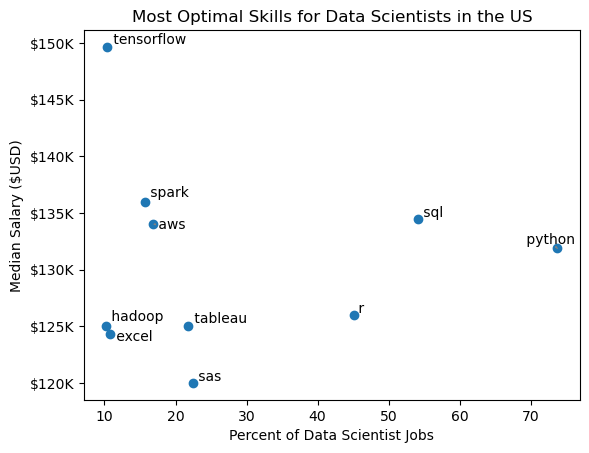

In [27]:
from adjustText import adjust_text

plt.scatter(df_DS_skills_high_demand['skill_percent'], df_DS_skills_high_demand['median_salary'])
plt.xlabel('Percent of Data Scientist Jobs')
plt.ylabel('Median Salary ($USD)')  # Assuming this is the label you want for y-axis
plt.title('Most Optimal Skills for Data Scientists in the US')

# Get current axes, set limits, and format axes
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))  # Example formatting y-axis

# Add labels to points and collect them in a list
texts = []
for i, txt in enumerate(df_DS_skills_high_demand.index):
    texts.append(plt.text(df_DS_skills_high_demand['skill_percent'].iloc[i], df_DS_skills_high_demand['median_salary'].iloc[i], " " + txt))

# Adjust text to avoid overlap and add arrows
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

plt.show()

In [ ]:
df_technology = df['job_type_skills'].copy()

# remove duplicates
df_technology = df_technology.drop_duplicates()

# remove NaN values
df_technology = df_technology.dropna()

# combine all dictionaries into one
technology_dict = {}
for row in df_technology:
    row_dict = ast.literal_eval(row)  # convert string to dictionary
    for key, value in row_dict.items():
        if key in technology_dict:  # if key already exists in technology_dict, add value to existing value
            technology_dict[key] += value
        else:                       # if key does not exist in technology_dict, add key and value
            technology_dict[key] = value

# remove duplicates by converting values to set then back to list
for key, value in technology_dict.items():
    technology_dict[key] = list(set(value))

technology_dict

In [29]:
# turn dictionary into dataframe
df_technology = pd.DataFrame(list(technology_dict.items()), columns=['technology', 'skills'])

df_technology = df_technology.explode('skills')

df_technology


,technology,skills
0,analyst_tools,sap
0,analyst_tools,nuix
0,analyst_tools,msaccess
0,analyst_tools,excel
0,analyst_tools,tableau
...,...,...
9,sync,wire
9,sync,microsoft teams
9,sync,symphony
9,sync,webex


In [34]:
# merge df_DS_skills and df_technology
df_plot = df_DS_skills.merge(df_technology, left_on='job_skills', right_on='skills').head(10)


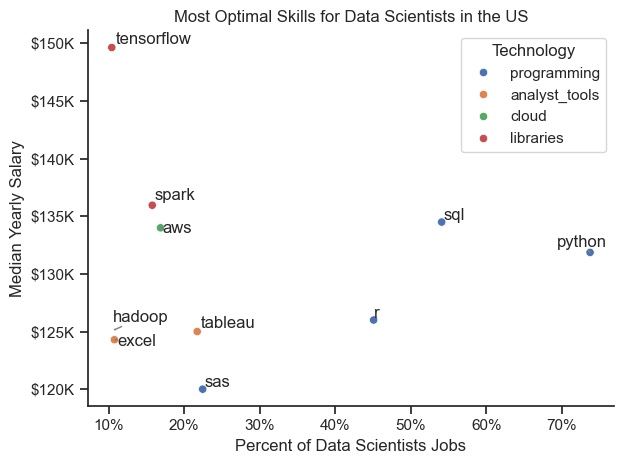

In [36]:
sns.scatterplot(
    data=df_plot,
    x='skill_percent',
    y='median_salary',
    hue='technology'
)

sns.despine()
sns.set_theme(style='ticks')

# Prepare texts for adjustText
texts = []
for i, txt in enumerate(df_DS_skills_high_demand.index):
    texts.append(plt.text(df_DS_skills_high_demand['skill_percent'].iloc[i], df_DS_skills_high_demand['median_salary'].iloc[i], txt))

# Adjust text to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

# Set axis labels, title, and legend
plt.xlabel('Percent of Data Scientists Jobs')
plt.ylabel('Median Yearly Salary')
plt.title('Most Optimal Skills for Data Scientists in the US')
plt.legend(title='Technology')

from matplotlib.ticker import PercentFormatter
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))
ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))

# Adjust layout and display plot 
plt.tight_layout()
plt.show()
